YF.download() has changed argument auto_adjust default to True


C:\Users\DELL\AppData\Local\Temp\ipykernel_38000\3586525493.py:62: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['signal'].iloc[i] = 1
C:\Users\DELL\AppData\Local\Temp\ipykernel_38000\3586525493.py:62: SettingWithCopyWarning: 
A value is 

Performance Metrics:
Initial Capital: 10000
Final Portfolio Value: 10000.0
Total Return: 0.00%
Max Drawdown: 0.00%
Sharpe Ratio: 0.0


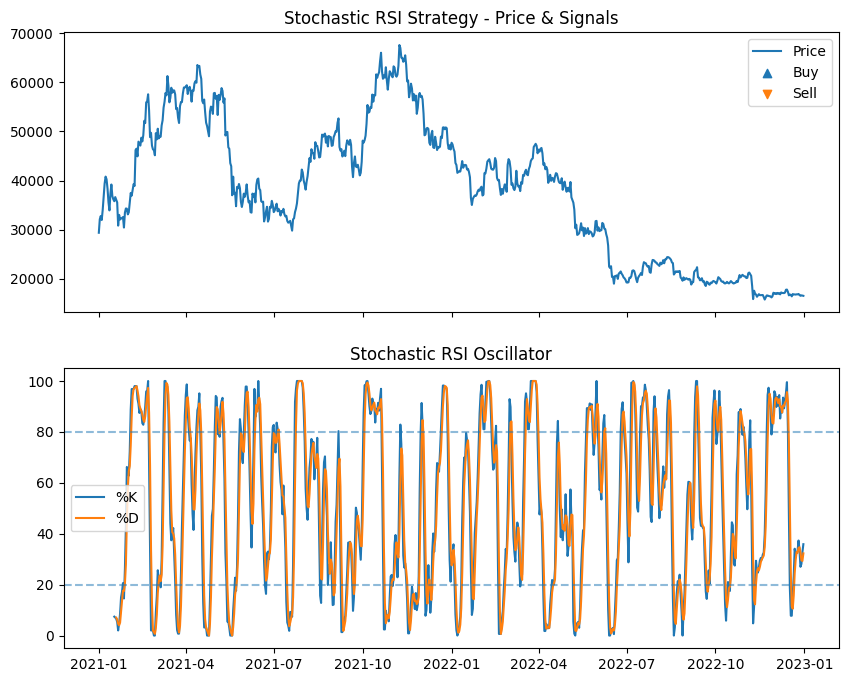

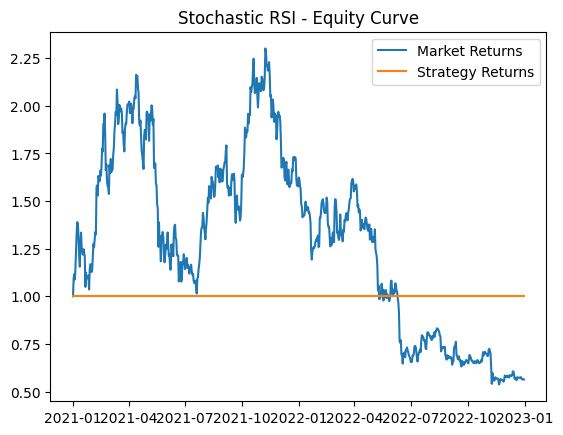

In [1]:
"""
stoch_rsi.py

A Stochastic RSI strategy:
- Looks for oversold/overbought conditions in RSI, then applies
  a stochastic oscillator logic on the RSI values.

Usage:
------
python stoch_rsi.py
or
%run stoch_rsi.py
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

def download_data(ticker="BTC-USD", start="2021-01-01", end="2023-01-01"):
    df = yf.download(ticker, start=start, end=end, progress=False)
    df.rename(columns={
        'Open': 'open',
        'High': 'high',
        'Low': 'low',
        'Close': 'close',
        'Adj Close': 'adj_close',
        'Volume': 'volume'
    }, inplace=True)
    df.dropna(inplace=True)
    return df

def compute_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).ewm(alpha=1/period).mean()
    loss = (-delta.where(delta < 0, 0)).ewm(alpha=1/period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def compute_stoch_rsi(df, k_period=3, d_period=3, rsi_period=14):
    rsi = compute_rsi(df['close'], period=rsi_period)
    lowest_rsi = rsi.rolling(rsi_period).min()
    highest_rsi = rsi.rolling(rsi_period).max()
    stoch_rsi = (rsi - lowest_rsi) / (highest_rsi - lowest_rsi + 1e-9)
    
    df['stoch_k'] = stoch_rsi.rolling(k_period).mean() * 100
    df['stoch_d'] = df['stoch_k'].rolling(d_period).mean()
    return df

def stoch_rsi_signals(df, lower=20, upper=80):
    """
    If stoch_k crosses above stoch_d below 'lower' => buy
    If stoch_k crosses below stoch_d above 'upper' => sell
    """
    df['signal'] = 0
    for i in range(1, len(df)):
        # Check cross up below 'lower'
        if (df['stoch_k'].iloc[i] > df['stoch_d'].iloc[i] 
            and df['stoch_k'].iloc[i-1] < df['stoch_d'].iloc[i-1]
            and df['stoch_k'].iloc[i] < lower):
            df['signal'].iloc[i] = 1
        
        # Check cross down above 'upper'
        elif (df['stoch_k'].iloc[i] < df['stoch_d'].iloc[i] 
              and df['stoch_k'].iloc[i-1] > df['stoch_d'].iloc[i-1]
              and df['stoch_k'].iloc[i] > upper):
            df['signal'].iloc[i] = -1
    return df

def backtest_strategy(df, initial_capital=10000):
    df['returns'] = df['close'].pct_change().fillna(0)
    df['strategy_returns'] = df['signal'].shift(1).fillna(0) * df['returns']
    df['cumulative_market'] = (1 + df['returns']).cumprod()
    df['cumulative_strategy'] = (1 + df['strategy_returns']).cumprod()
    
    final_value = initial_capital * df['cumulative_strategy'].iloc[-1]
    total_return = (final_value - initial_capital) / initial_capital

    drawdown = (
        (df['cumulative_strategy'].cummax() - df['cumulative_strategy'])
        / df['cumulative_strategy'].cummax()
    )
    max_drawdown = drawdown.max()
    sharpe_ratio = (
        df['strategy_returns'].mean() / (df['strategy_returns'].std() + 1e-9)
    ) * np.sqrt(252)
    
    result = {
        "Initial Capital": initial_capital,
        "Final Portfolio Value": round(final_value, 2),
        "Total Return": f"{total_return*100:.2f}%",
        "Max Drawdown": f"{max_drawdown*100:.2f}%",
        "Sharpe Ratio": round(sharpe_ratio, 2)
    }
    return df, result

def plot_results(df):
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10, 8))
    ax[0].plot(df.index, df['close'], label='Price')
    buy_signals = df[df['signal'] == 1]
    sell_signals = df[df['signal'] == -1]
    ax[0].scatter(buy_signals.index, buy_signals['close'], marker='^', label='Buy')
    ax[0].scatter(sell_signals.index, sell_signals['close'], marker='v', label='Sell')
    ax[0].set_title("Stochastic RSI Strategy - Price & Signals")
    ax[0].legend()
    
    ax[1].plot(df.index, df['stoch_k'], label='%K')
    ax[1].plot(df.index, df['stoch_d'], label='%D')
    ax[1].axhline(20, linestyle='--', alpha=0.5)
    ax[1].axhline(80, linestyle='--', alpha=0.5)
    ax[1].legend()
    ax[1].set_title("Stochastic RSI Oscillator")
    plt.show()
    
    plt.plot(df.index, df['cumulative_market'], label='Market Returns')
    plt.plot(df.index, df['cumulative_strategy'], label='Strategy Returns')
    plt.title("Stochastic RSI - Equity Curve")
    plt.legend()
    plt.show()

if __name__ == "__main__":
    data = download_data("BTC-USD", "2021-01-01", "2023-01-01")
    data = compute_stoch_rsi(data, k_period=3, d_period=3, rsi_period=14)
    data = stoch_rsi_signals(data, lower=20, upper=80)
    data, metrics = backtest_strategy(data, initial_capital=10000)
    
    print("Performance Metrics:")
    for k,v in metrics.items():
        print(f"{k}: {v}")
    
    plot_results(data)
